In [1]:
import openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Load the dataset from OpenML

In [2]:
dataset = openml.datasets.get_dataset(61, download_all_files=True)  # iris
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

/tmp/ipykernel_1575894/3635851383.py:1: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(61, download_all_files=True)  # iris


Ensure test set contains at least one instance of each class

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Define classifiers and hyperparameters for GridSearchCV

In [4]:
classifiers = {
    'DecisionTree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 10, 20]}),
    'MLP': (MLPClassifier(), {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['tanh', 'relu'], 'solver': ['adam', 'sgd']}),
    'LogisticRegression': (LogisticRegression(), {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
}

Run GridSearchCV for each classifier and store results


In [5]:
results = {}
best_estimators = {}

for clf_name, (clf, params) in classifiers.items():
    params['random_state'] = [42]
    print(f'Running GridSearchCV for {clf_name} with parameters {params}')
    grid_search = GridSearchCV(clf, param_grid=params, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Save the cross-validation scores and best estimator
    results[clf_name] = grid_search.cv_results_['mean_test_score']
    best_estimators[clf_name] = grid_search.best_estimator_

Running GridSearchCV for DecisionTree with parameters {'max_depth': [None, 10, 20], 'min_samples_split': [2, 10, 20], 'random_state': [42]}
Fitting 10 folds for each of 9 candidates, totalling 90 fits


Running GridSearchCV for MLP with parameters {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['tanh', 'relu'], 'solver': ['adam', 'sgd'], 'random_state': [42]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/home/gciatto/Work/Courses/ml-experiment/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gciatto/Work/Courses/ml-experiment/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gciatto/Work/Courses/ml-experiment/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gciatto/Work/Courses/ml-experiment/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

Running GridSearchCV for LogisticRegression with parameters {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs'], 'random_state': [42]}
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Running GridSearchCV for SVM with parameters {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'random_state': [42]}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


Compare validation performance with a boxplot

/tmp/ipykernel_1575894/685773276.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


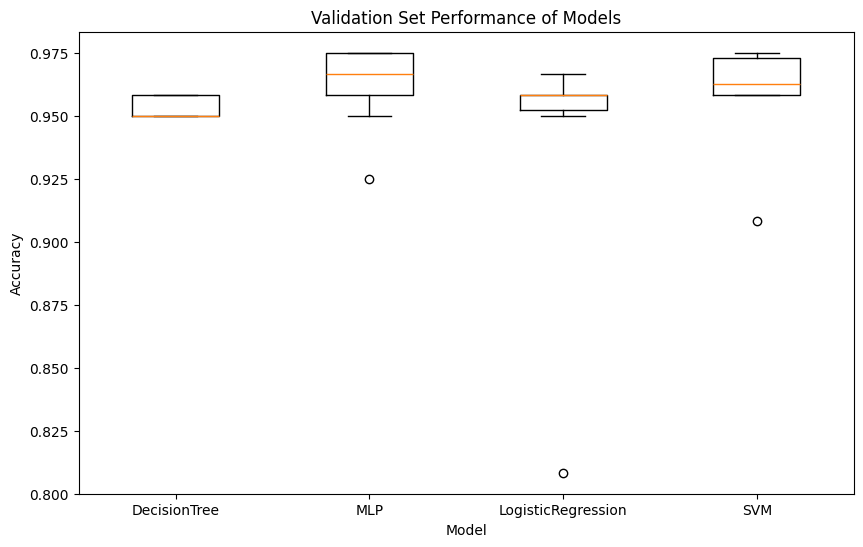

In [6]:
plt.figure(figsize=(10, 6))
plt.boxplot(results.values(), labels=results.keys())
plt.title('Validation Set Performance of Models')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.savefig('validation_set_performance.png')
plt.show()

Select the best model and evaluate on test set

In [7]:
best_model_name = max(results, key=lambda k: max(results[k]))
best_model = best_estimators[best_model_name]
best_model.fit(X_train, y_train)

/home/gciatto/Work/Courses/ml-experiment/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', random_state=42)

Test set evaluation

In [8]:
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

In [9]:
print(f'Best Model: {best_model_name}')
print(f'Test Set Accuracy: {test_accuracy:.4f}')

Best Model: MLP
Test Set Accuracy: 1.0000


Save the best model to disk

In [10]:
import pickle

with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)